<a href="https://colab.research.google.com/github/Vejaem/Final-Project/blob/main/Whole_dataset_Logistical_Regression_BARTHAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
# spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

## import matplotlib, etc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.18.jar").getOrCreate()

In [ ]:
# Read in data from S3 Buckets
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://markdatabucket.s3.amazonaws.com/cbb.csv"

spark.sparkContext.addFile(url)
spark_data_df = spark.read.csv(SparkFiles.get("cbb.csv"), sep=",", header=True, inferSchema=True)

# need to convert spark dataframe to pandas dataframe
cbb_df = spark_data_df.toPandas()

# Show DataFrame
cbb_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1,2017


In [ ]:
# duplicate postseason column to later use as binary option
cbb_df['POSTSEASON_BINARY'] = cbb_df['POSTSEASON']
cbb_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_BINARY
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016,2ND
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015,2ND
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018,2ND
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019,2ND
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1,2017,2ND


In [ ]:
cbb_df['POSTSEASON_BINARY'] = cbb_df['POSTSEASON']
cbb_df.POSTSEASON_BINARY[cbb_df.POSTSEASON_BINARY == "NA"] = 0
cbb_df.POSTSEASON_BINARY[cbb_df.POSTSEASON_BINARY != 0] = 1
cbb_df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_BINARY
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016,1
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015,1
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018,1
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019,1
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1,2017,1
5,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,18.6,35.8,30.2,39.8,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1,2015,1
6,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1,2019,1
7,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,18.6,41.3,25.0,34.3,31.6,51.0,46.3,35.5,33.9,72.8,8.4,Champions,1,2017,1
8,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,20.6,28.2,29.4,34.1,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2,2016,1
9,Villanova,BE,40,36,128.4,94.1,0.9725,59.5,48.5,15.0,18.2,29.6,27.1,29.4,26.7,59.0,49.0,40.1,31.7,69.6,10.6,Champions,1,2018,1


In [ ]:
# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values
# so we use reshape to create this

X = cbb_df.BARTHAG.values.reshape(-1, 1)
y = cbb_df.POSTSEASON_BINARY
y=y.astype('int')

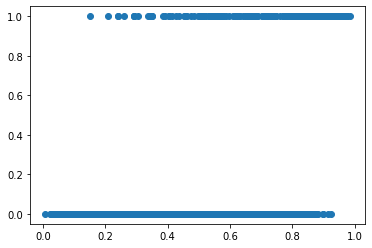

In [ ]:
# Plot the data
plt.scatter(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [ ]:
# Create the model and fit the model to the data

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:

classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9028094153378892
Testing Data Score: 0.8863636363636364


In [ ]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 0 1 0 0 0 0]
First 10 Actual labels: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
...,...,...
435,1,1
436,0,0
437,0,0
438,1,1
